In [1]:
from LensCalcPy.survey import *
from LensCalcPy.ffp import *
from LensCalcPy.utils import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d, interp2d
from scipy.integrate import quad, nquad
from tqdm import tqdm
from pathos.multiprocessing import ProcessingPool as Pool
import functools
from scipy.stats import poisson
import seaborn as sns
sns.set_palette("colorblind")

%load_ext autoreload
%autoreload 2

In [2]:
plt.style.use("style.mplstyle")
sns.set_palette("colorblind")

In [3]:
from LensCalcPy.parameters import *

In [4]:
def plot_line_of_sight(s, ax):
    d_arr = np.linspace(1, s.source_dist, num=1000)

    rho_ffp_mw = [s.mw_model.density_stars(d, l = s.l, b = s.b) for d in d_arr]
    rho_ffp_m31 = [s.m31_model.density_stars(d) for d in d_arr]
    rho_dm_mw = [s.mw_model.density_dm(d, l = s.l, b = s.b) for d in d_arr]
    rho_dm_m31 = [s.m31_model.density_dm(d) for d in d_arr]

    ax.plot(d_arr, rho_ffp_mw, label="MW UBOs")
    ax.plot(d_arr, rho_dm_mw, label="MW DM", linestyle="--", color="C0")

    if not s.use_mw_source:
        ax.plot(d_arr, rho_ffp_m31, label="M31 UBOs")
        ax.plot(d_arr, rho_dm_m31, label="M31 DM", linestyle="--", color="C1")

    ax.set_xlabel(r"$d$ [kpc]", fontsize=16)
    ax.set_ylabel(r"$\rho$ [M$_\odot$/$\mathrm{kpc}^3$]", fontsize=16)
    if s.use_mw_source:
        ax.set_title(r'MW Survey - LoS: l = ${:.2f}^\circ$, b = ${:.2f}^\circ$'.format(s.l, s.b), fontsize=16)
    else:
        ax.set_title(r'M31 Survey - LoS: l = ${:.2f}^\circ$, b = ${:.2f}^\circ$'.format(s.l, s.b), fontsize=16)

    ax.legend(fontsize=14)

    ax.set_yscale("log")
    ax.set_xlim(1e0, s.source_dist)
    ax.set_ylim(1e2, 1e10)


In [5]:
obs_time_ogle = 5 * 365 * 24 

In [6]:
ogle_df = pd.read_csv('ogle_sensitivity.csv', header=None, names=['log_10(t/d)', 'efficiency'])

In [7]:
ogle_efficiency_interp = interp1d(ogle_df['log_10(t/d)'], ogle_df['efficiency'])

In [8]:
def ogle_efficiency(t):
    '''
    Takes in crossing time in hours and returns the efficiency of OGLE
    '''
    t_day = t/24
    log10_t_day = np.log10(t_day)
    if log10_t_day <= np.min(ogle_df['log_10(t/d)']):
        return ogle_df['efficiency'][0]
    if log10_t_day >= np.max(ogle_df['log_10(t/d)']):
        return ogle_df['efficiency'][len(ogle_df)-1]
    return(ogle_efficiency_interp(log10_t_day))

def hsc_efficiency(t):
    return 0.7

In [9]:
#! survey_area should really be diameter, but not used in any calculations

# ogle obs_time 5 years
# change cadence for different fields
# add efficiency (ogle uses extended fig 2 of https://arxiv.org/pdf/1707.07634.pdf), hsc already done in ffp_upper nb. Cadence taken from same paper

survey_param_dict = {
    "hsc": {"l": 121.2, "b": -21.6, "source_dist": 770, "obs_time": 7, "cadence": 0.035, "survey_area": 1.5, "n_sources": 8.7e7, "efficiency": hsc_efficiency, "use_mw_source":False},
    "hsc_blg500": {"l": 1.0, "b": -1.03, "source_dist": 8.5, "obs_time": 7, "cadence": 0.035, "survey_area": 1.5, "n_sources": 4.0e6, "efficiency": hsc_efficiency, "use_mw_source":True},
    "lsst": {"l": 330.0, "b": 20.0, "source_dist": 8.5, "obs_time": 12.5, "cadence": 0.035, "survey_area": 9.6, "n_sources": 1.2e6, "efficiency": hsc_efficiency, "use_mw_source":True},
    "ogle_blg500": {"l": 0.9999, "b": -1.0293, "source_dist": 8.5, "obs_time": obs_time_ogle, "cadence": 60/60, "survey_area": 1.5, "n_sources": 4.0e6, "efficiency": ogle_efficiency, "use_mw_source": True, "A_t": 1.10},
    "ogle_blg501": {"l": 359.9392, "b": -1.6400, "source_dist": 8.5, "obs_time": obs_time_ogle, "cadence": 20/60, "survey_area": 1.5, "n_sources": 5.2e6, "efficiency": ogle_efficiency, "use_mw_source": True, "A_t": 1.10},
    "ogle_blg504": {"l": 2.1491, "b": -1.7747, "source_dist": 8.5, "obs_time": obs_time_ogle, "cadence": 60/60, "survey_area": 1.5, "n_sources": 5.8e6, "efficiency": ogle_efficiency, "use_mw_source": True, "A_t": 1.10},
    "ogle_blg505": {"l": 1.0870, "b": -2.3890, "source_dist": 8.5, "obs_time": obs_time_ogle, "cadence": 20/60, "survey_area": 1.5, "n_sources": 6.9e6, "efficiency": ogle_efficiency, "use_mw_source": True, "A_t": 1.10},
    "ogle_blg506": {"l": 0.0103, "b": -2.9974, "source_dist": 8.5, "obs_time": obs_time_ogle, "cadence": 60/60, "survey_area": 1.5, "n_sources": 5.3e6, "efficiency": ogle_efficiency, "use_mw_source": True, "A_t": 1.10},
    "ogle_blg511": {"l": 3.2835, "b": -2.5219, "source_dist": 8.5, "obs_time": obs_time_ogle, "cadence": 60/60, "survey_area": 1.5, "n_sources": 5.5e6, "efficiency": ogle_efficiency, "use_mw_source": True, "A_t": 1.10},
    "ogle_blg512": {"l": 2.2154, "b": -3.1355, "source_dist": 8.5, "obs_time": obs_time_ogle, "cadence": 20/60, "survey_area": 1.5, "n_sources": 6.9e6, "efficiency": ogle_efficiency, "use_mw_source": True, "A_t": 1.10},
    "ogle_blg534": {"l": 358.8644, "b": -2.2547, "source_dist": 8.5, "obs_time": obs_time_ogle, "cadence": 60/60, "survey_area": 1.5, "n_sources": 4.2e6, "efficiency": ogle_efficiency, "use_mw_source": True, "A_t": 1.10},
    "ogle_blg611": {"l": 0.3282, "b": 2.8242, "source_dist": 8.5, "obs_time": obs_time_ogle, "cadence": 60/60, "survey_area": 1.5, "n_sources": 5.0e6, "efficiency": ogle_efficiency, "use_mw_source": True, "A_t": 1.10}

}

/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/LensCalcPy/galaxy.py:200: RuntimeWarning: divide by zero encountered in double_scalars
  return rhocM31 / ((r/rsM31) * (1 + r/rsM31)**2)


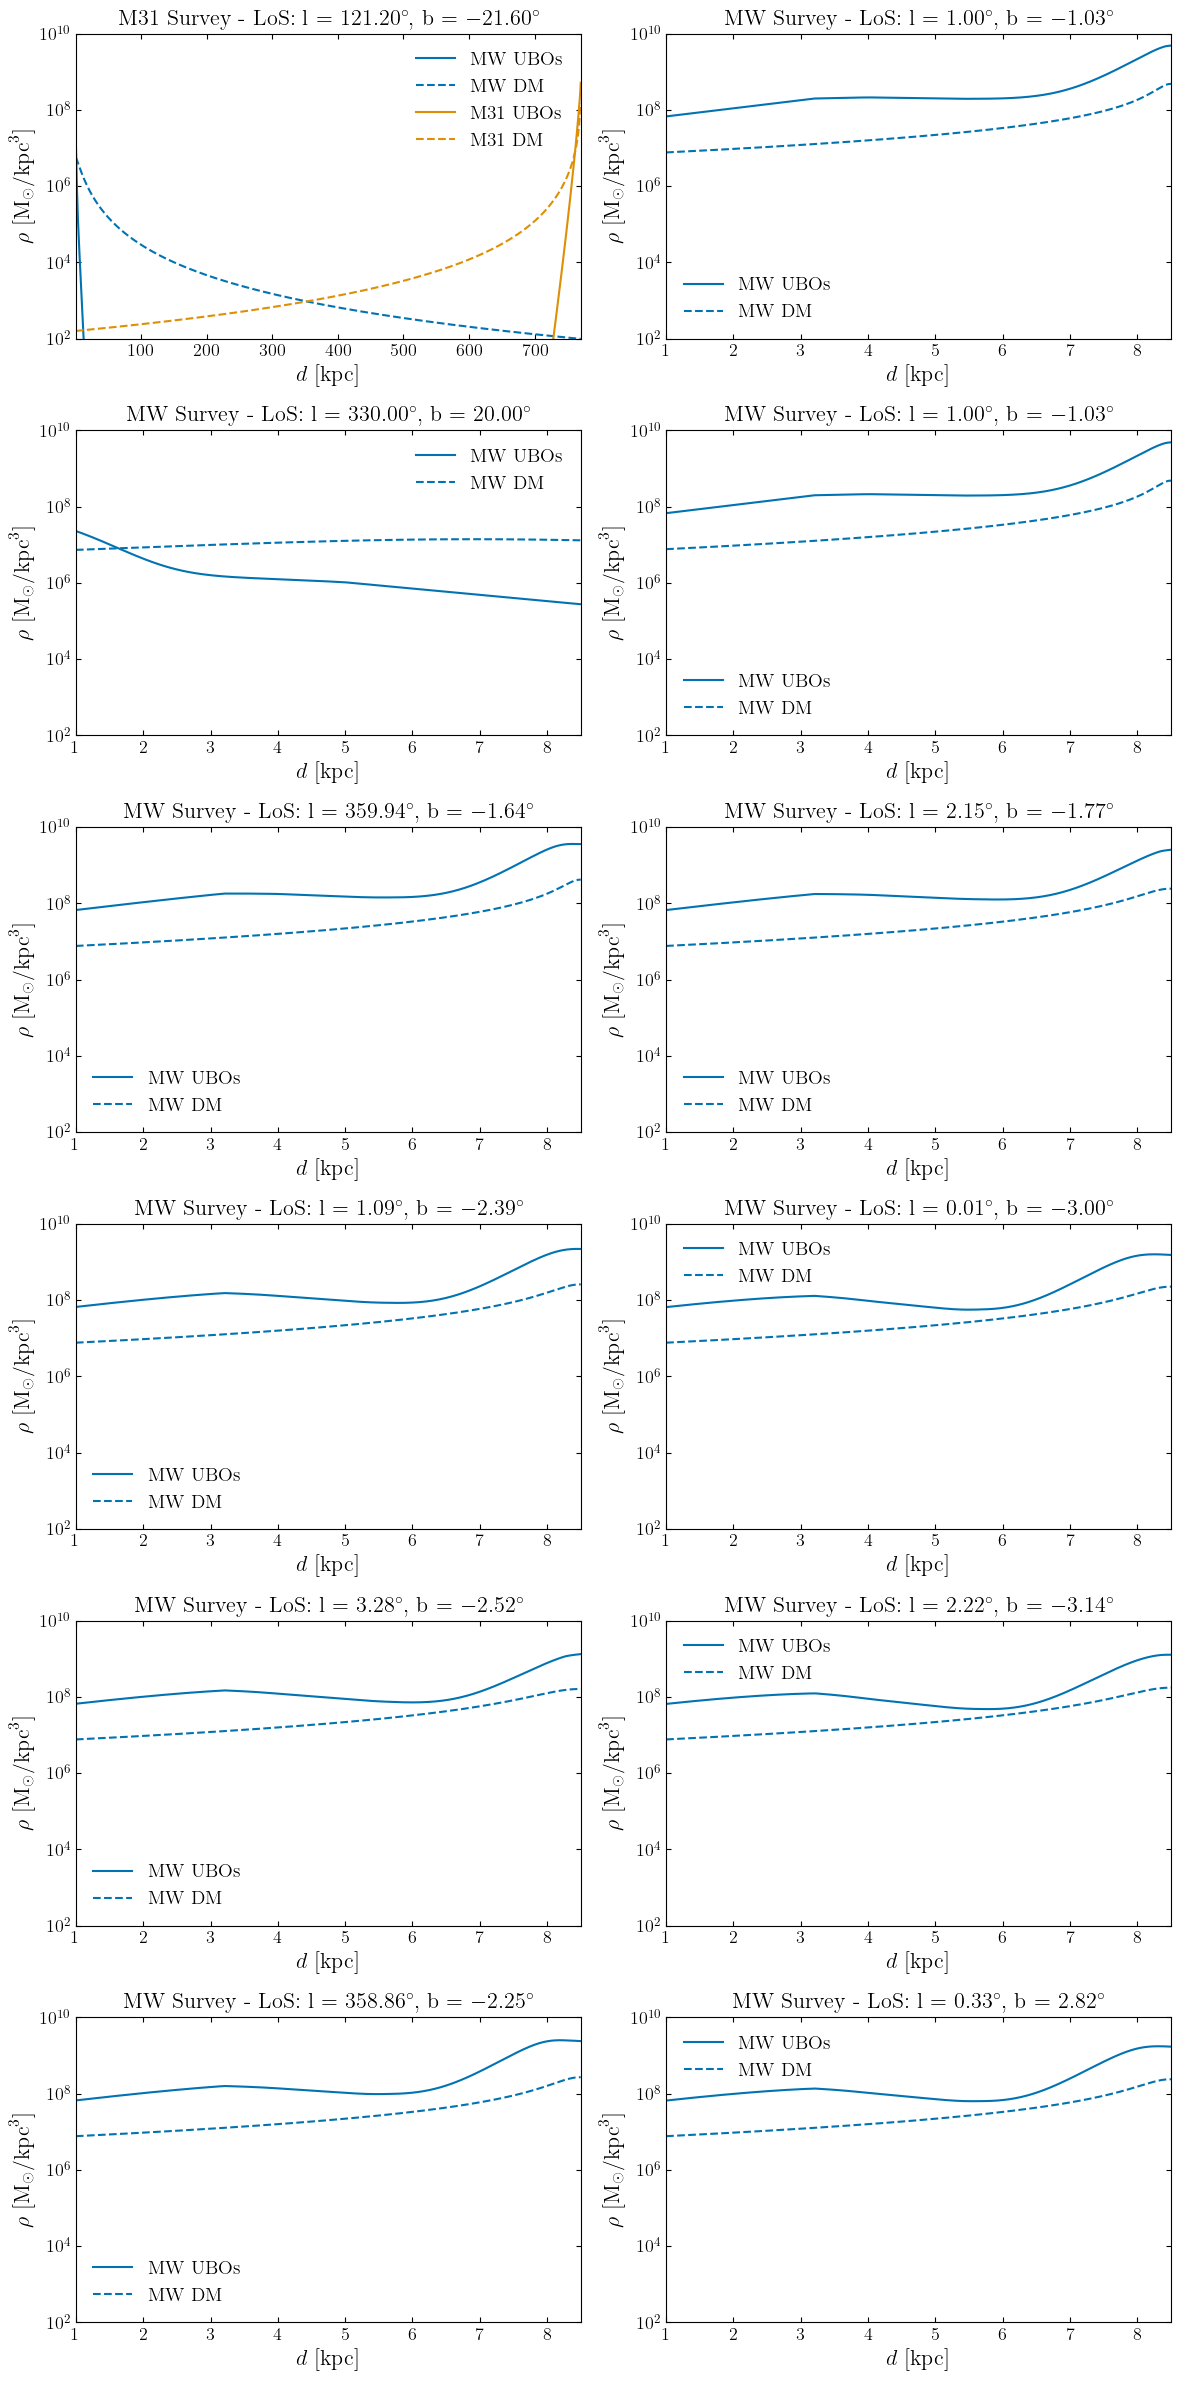

In [10]:
n_params = len(survey_param_dict)
n_cols = 2
n_rows = (n_params + n_cols - 1) // n_cols

# Create a figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))
axes = axes.flatten()  

# Loop through the parameter sets and create subplots
for i, param_set in enumerate(survey_param_dict.values()):
    s = Survey(**param_set)
    ax = axes[i]
    plot_line_of_sight(s, ax)

plt.tight_layout()

In [11]:
#J-factor like metric to compare density of UBOs
def ubo_factor(s):
    #integrated density of UBOs along line of sight (not include finite size effects)
    d_arr = np.linspace(0, s.source_dist, 1000) #kpc
    rho_ffp_mw = [s.mw_model.density_stars(d, l = s.l, b = s.b) for d in d_arr]
    rho_ffp_m31 = [s.m31_model.density_stars(d, l = s.l, b = s.b) for d in d_arr]
    
    rho_ffp_interp = interp1d(d_arr, rho_ffp_mw)
    rho_ffp_m31_interp = interp1d(d_arr, rho_ffp_m31)

    return quad(rho_ffp_interp, 0, s.source_dist)[0] + quad(rho_ffp_m31_interp, 0, s.source_dist)[0]

Expected number of events

In [12]:
# t_es = np.logspace(np.log10(s.cadence*2), np.log10(s.obs_time/2), 30) #hours
t_es = np.logspace(np.log10(0.01), np.log10(s.obs_time/2), 30) #hours

s_hsc = Survey(**{"l": 121.2, "b": -21.6, "source_dist": 770, "obs_time": 7, "cadence": 0.035, "survey_area": 1.5, "n_sources": 8.7e7, "efficiency": hsc_efficiency, "use_mw_source":False})
s_ogle501 = Survey(**{"l": 359.9392, "b": -1.6400, "source_dist": 8.5, "obs_time": obs_time_ogle, "cadence": 20/60, "survey_area": 1.5, "n_sources": 5.2e6, "efficiency": ogle_efficiency, "use_mw_source": True, "A_t": 1.10},)
s_hsc.add_ffp(1.0)
s_ogle501.add_ffp(1.0)

diff_rates_hsc = s_hsc.get_crossing_times_rates_ffp(t_es, finite=True)
efficiencies_hsc = np.array([s_hsc.efficiency(t_e) for t_e in t_es])
diff_rates_w_efficiency_hsc = diff_rates_hsc*efficiencies_hsc
diff_rates_ogle = s_ogle501.get_crossing_times_rates_ffp(t_es, finite=True)
efficiencies_ogle = np.array([s.efficiency(t_e) for t_e in t_es])
diff_rates_w_efficiency_ogle = diff_rates_ogle*efficiencies_ogle


In [13]:
norm_fac = 10/s_ogle501.ffp.Z*(3e-6/s_ogle501.ffp.M_norm)**(-s_ogle501.ffp.p) 

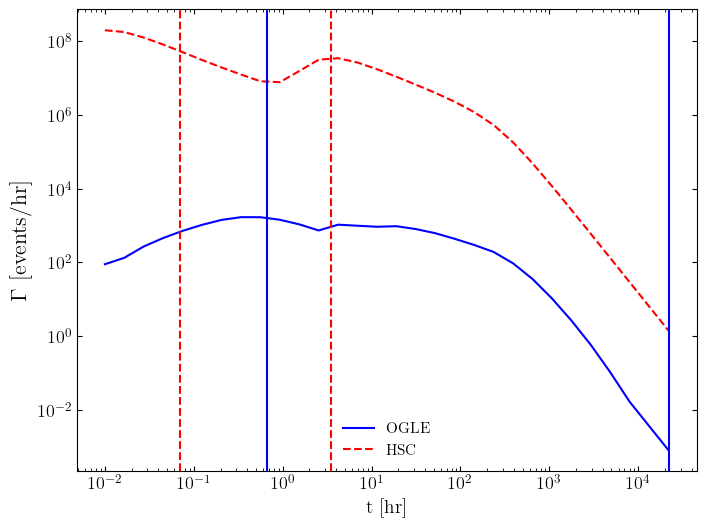

In [97]:
plt.loglog(t_es, diff_rates_w_efficiency_ogle*norm_fac*t_es*s_ogle501.n_sources, label='OGLE', color='b')
plt.loglog(t_es, diff_rates_w_efficiency_hsc*norm_fac*t_es*s_hsc.n_sources, ls='--', label='HSC', color='r')

plt.axvline(s_ogle501.cadence*2, color='b')
plt.axvline(s_ogle501.obs_time/2, color='b')

plt.axvline(s_hsc.cadence*2, ls='--', color='r')
plt.axvline(s_hsc.obs_time/2, ls='--', color='r')

plt.xlabel('t [hr]')
plt.ylabel(r"$\Gamma$ [events/hr]", fontsize=16)
plt.legend()
plt.show()

In [15]:
def get_n_events(s, p=1, finite=True):
    #get expected number of events for pdf-powerlaw. Note that you need to normalize this
    # t_es = np.linspace(s.cadence*2, s.obs_time/2, 30) #need more than 20 steps for ogle? Probably not since mass function super suppressed for large masses
    t_es = np.logspace(np.log10(s.cadence*2), np.log10(s.obs_time/2), 30) 

    s.add_ffp(p)
    diff_rates = s.get_crossing_times_rates_ffp(t_es, finite=finite)
    # efficiencies = np.array([ogle_efficiency(t_e) for t_e in t_es])
    efficiencies = np.array([s.efficiency(t_e) for t_e in t_es])
    diff_rates_w_efficiency = diff_rates*efficiencies
    # rate_interp = interp1d(t_es, diff_rates)
    rate_interp = interp1d(t_es, diff_rates_w_efficiency)
    if s.cadence*2 > s.obs_time/2:
        raise ValueError("Cadence is too short relative to total observation time")
    #? using 2x the cadence and 1/2 the observation time for now. Comparable to Fig 18 of https://arxiv.org/pdf/1701.02151.pdf sensitivity
    dnds = quad(rate_interp, s.cadence*2, s.obs_time/2)[0]
    # return s.n_sources*s.efficiency*dnds*s.obs_time
    return s.n_sources*dnds*s.obs_time


In [16]:
def get_num_events_fiducial(s, finite=True):

    #power law, normalization, and normalization mass for fiducial mass function
    p = 1
    Z_fiducial = 10
    M_norm = 3e-6 #earth mass in solar mass units

    #number of events for a power law normalized to 1 UBO per star total
    #! Check that this is using the correct l and b
    n_events = get_n_events(s, p=p, finite=finite)

    #rescale normalization of pdf to M_norm = earth mass if not already
    z_earth = s.ffp.Z*(M_norm/s.ffp.M_norm)**(-p) 

    #number of objects per star for fiducial mass function at 1 earth mass

    num_events_fiducial = n_events * Z_fiducial/z_earth

    return num_events_fiducial

In [17]:
def compute_expected_num_events(survey_name_and_params):
    survey_name, param_set = survey_name_and_params
    s = Survey(**param_set)
    expected_num_events_finite = get_num_events_fiducial(s, finite=True)
    expected_num_events_point = get_num_events_fiducial(s, finite=False)
    return survey_name, expected_num_events_finite, expected_num_events_point

survey_name_and_params_list = [(survey_name, params) for survey_name, params in survey_param_dict.items()]

with Pool() as pool:
    results = pool.map(compute_expected_num_events, survey_name_and_params_list)


In [18]:
num_events_dict = {}
num_events_point_dict = {}

for survey_name, expected_num_events_finite, expected_num_point_events in results:
    num_events_dict[survey_name] = expected_num_events_finite
    num_events_point_dict[survey_name] = expected_num_point_events

In [19]:
ubo_factor_dict = {}
for i, survey_name in enumerate(survey_param_dict.keys()):
    param_set = survey_param_dict[survey_name]
    s = Survey(**param_set)
    ubo_factor_dict[survey_name] = ubo_factor(s)

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_63334/2506563490.py:11: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(rho_ffp_interp, 0, s.source_dist)[0] + quad(rho_ffp_m31_interp, 0, s.source_dist)[0]
/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_63334/2506563490.py:11: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(rho_ffp_interp, 0, s.source_dist)[0] + quad(rho_ffp_m31_interp, 0, s.source_dist)[0]


In [20]:
# Create a list of dictionaries for the table
table_data = []
for survey_name, param_set in survey_param_dict.items():
    row = {
        "Survey": survey_name,
        "l": param_set["l"],
        "b": param_set["b"],
        "n_sources": param_set["n_sources"],
        "ubo_factor": ubo_factor_dict[survey_name],
        "obs_time": param_set["obs_time"],
        # "num_expected_events_tot": num_events_dict[survey_name],
        "N/h finite": float(num_events_dict[survey_name]) / float(param_set["obs_time"]),
        # "num_expected_events_point_tot": num_events_point_dict[survey_name],
        "N/h point": float(num_events_point_dict[survey_name]) / float(param_set["obs_time"]),
        "finite_factor": (float(num_events_dict[survey_name]) / float(param_set["obs_time"]))/(float(num_events_point_dict[survey_name]) / float(param_set["obs_time"]))

    }
    table_data.append(row)

df = pd.DataFrame(table_data)
df = df[["Survey", "l", "b", "n_sources", "ubo_factor", "obs_time", "N/h finite", "N/h point", "finite_factor"]]


In [21]:
# Define a function to format large numbers in scientific notation
def scientific_format(x):
    return '{:.4e}'.format(x)

# Apply styling to the DataFrame
styled_df = (
    df.style
    .format({
        'l': '{:.1f}',
        'b': '{:.1f}',
        'n_sources': '{:.1e}',
        'ubo_factor': '{:.1e}',
        'obs_time': '{:.1f}',
        # 'num_expected_events_tot': '{:.1e}',
        'N/h finite': '{:.1e}',
        # 'num_expected_events_point_tot': '{:.1e}',
        'N/h point': '{:.1e}',
        'finite_factor': '{:.1e}',
        
    })
    .set_table_styles([
        {'selector': 'th', 'props': [('font-size', '14pt'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('font-size', '12pt'), ('text-align', 'center')]}
    ])
    .set_caption('Survey Parameters and Expected Events')
)

styled_df


,Survey,l,b,n_sources,ubo_factor,obs_time,N/h finite,N/h point,finite_factor
0,hsc,121.2,-21.6,8.7e+07,9.5e+08,7.0,7.1e-04,4.7e-03,1.5e-01
1,hsc_blg500,1.0,-1.0,4.0e+06,3.9e+09,7.0,2.1e-06,1.5e-05,1.3e-01
2,lsst,330.0,20.0,1.2e+06,5.5e+07,12.5,6.6e-07,4.7e-06,1.4e-01
3,ogle_blg500,1.0,-1.0,4.0e+06,3.9e+09,43800.0,1.9e-08,1.9e-08,1.0e+00
4,ogle_blg501,359.9,-1.6,5.2e+06,3.8e+09,43800.0,2.6e-08,2.6e-08,1.0e+00
5,ogle_blg504,2.1,-1.8,5.8e+06,2.5e+09,43800.0,2.7e-08,2.7e-08,1.0e+00
6,ogle_blg505,1.1,-2.4,6.9e+06,2.5e+09,43800.0,3.4e-08,3.4e-08,1.0e+00
7,ogle_blg506,0.0,-3.0,5.3e+06,2.2e+09,43800.0,2.5e-08,2.5e-08,1.0e+00
8,ogle_blg511,3.3,-2.5,5.5e+06,1.6e+09,43800.0,2.6e-08,2.6e-08,1.0e+00
9,ogle_blg512,2.2,-3.1,6.9e+06,1.6e+09,43800.0,3.4e-08,3.4e-08,1.0e+00


In [22]:
#shooting for around 10ish total

ogle_surveys = df[df['Survey'].str.startswith('ogle')]

total_finite_events_ogle = (ogle_surveys['N/h finite'] * ogle_surveys['obs_time']).sum()
total_point_events_ogle = (ogle_surveys['N/h point'] * ogle_surveys['obs_time']).sum()

print("Total number of events detected by OGLE, inluding finite-source effects:", total_finite_events_ogle)
print("Total number of point events detected by OGLE, point source:", total_point_events_ogle)

Total number of events detected by OGLE, inluding finite-source effects: 0.010149922250331643
Total number of point events detected by OGLE, point source: 0.01017132157059763


In [52]:
total_finite_events_hsc = (df[df["Survey"]=="hsc"]['N/h finite'] * df[df["Survey"]=="hsc"]['obs_time'])[0]
print("Total number of events detected by HSC, inluding finite-source effects:", total_finite_events_hsc)

Total number of events detected by HSC, inluding finite-source effects: 0.005000233251768035


### OGLE Checks

In [63]:
mono_rates_hsc = np.array([s_hsc.ffp.differential_rate_mw_monochromatic(t, finite=True, m=1e-5) for t in t_es])
mono_rates_ogle501 = np.array([s_ogle501.ffp.differential_rate_mw_monochromatic(t, finite=True, m=1e-5) for t in t_es])

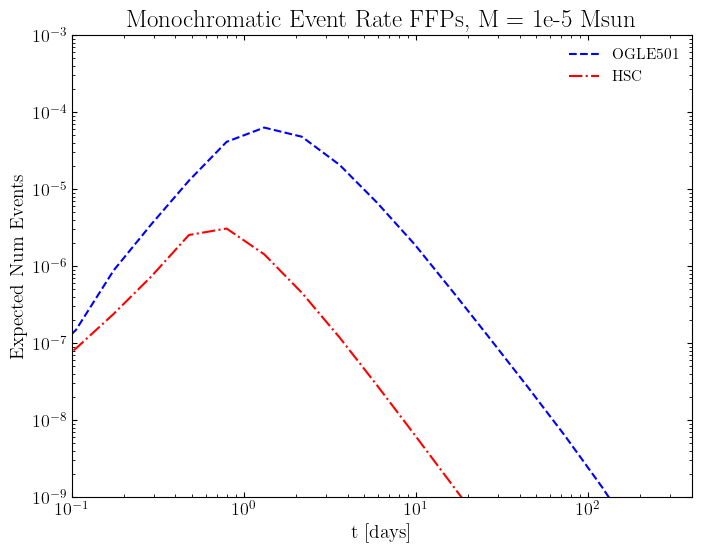

In [109]:
plt.loglog(t_es/24, mono_rates_ogle501*t_es*s_ogle501.obs_time*s_ogle501.n_sources*efficiencies_ogle, 'b', ls='--', label='OGLE501')
plt.loglog(t_es/24, mono_rates_hsc*t_es*s_hsc.obs_time*s_hsc.n_sources*efficiencies_hsc, 'r', ls='-.', label='HSC')
# plt.loglog(t_es/24, mono_rates_ogle501*t_es*s_ogle501.n_sources, 'b', ls='--', label='OGLE')
# plt.loglog(t_es/24, mono_rates_hsc*t_es*s_hsc.n_sources, 'r', ls='-.', label='HSC')
plt.ylim(1e-9, 1e-3)
plt.xlim(1e-1, 4e2)
plt.xlabel('t [days]')
plt.ylabel('Expected Num Events')
# plt.ylabel('Expected Num Events/hr observed')

plt.title('Monochromatic Event Rate FFPs, M = 1e-5 Msun')
plt.legend()
plt.show()

In [85]:
s_hsc.add_pbh(1e-4)
s_ogle501.add_pbh(1e-4)

In [86]:
pbh_rates_hsc = np.array([s_hsc.pbh.differential_rate_mw(t, finite=True) for t in t_es])
pbh_rates_ogle501 = np.array([s_ogle501.pbh.differential_rate_mw(t, finite=True) for t in t_es])

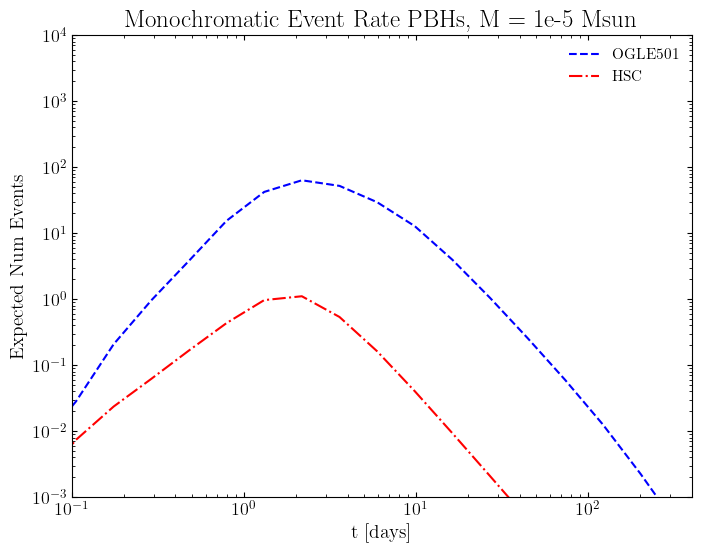

In [114]:
plt.loglog(t_es/24, pbh_rates_hsc*t_es*s_ogle501.obs_time*efficiencies_ogle*s_ogle501.n_sources, 'b', ls='--', label='OGLE501')
plt.loglog(t_es/24, pbh_rates_ogle501*t_es*s_hsc.obs_time*efficiencies_hsc*s_hsc.n_sources, 'r', ls='-.', label='HSC')
plt.ylim(1e-3, 1e4)
plt.xlim(1e-1, 4e2)
plt.xlabel('t [days]')
plt.ylabel('Expected Num Events')
plt.title('Monochromatic Event Rate PBHs, M = 1e-5 Msun')
plt.legend()
plt.show()